


# PyTorch Basics

I'll assume that everyone is familiar with Python. Training neural nets in bare Python is somewhat painful, but fortunately there are several well-established libraries which can help. I like PyTorch, which is built upon an earlier library called Torch. (There are many others, including TensorFlow and Jax, both of which I would encourage you to explore at your leisure.)


In [23]:
!{sys.executable} -m pip install numpy torch torchvision matplotlib

  Using cached contourpy-1.3.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 25.7 MB/s eta 0:00:00 MB/s eta 0:00:01
Using cached contourpy-1.3.1-cp313-cp313-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 31.6 MB/s eta 0:00:00
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [28]:
import numpy as np
import torch
import torchvision

Torch believes that everything is a *tensor*.

In [29]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

print(a)
print(b)

[[0.89991378 0.48395858 0.02731701]
 [0.84150089 0.00774621 0.91548007]]
tensor([[0.8999, 0.4840, 0.0273],
        [0.8415, 0.0077, 0.9155]], dtype=torch.float64)


The main intuition is that tensors allow for intuitive and efficient matrix multiplication across different indexing dimensions. Soon we will see that training neural nets basically involves *forward* and *backward* passes, both of which are essentially matrix multiplies.

The other thing about Torch variables is that they (natively) can be differentiated. (Again, we will see why this is important when we learn about backpropagation in deep learning.) 

In [30]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1,requires_grad=True)

y = torch.matmul(A,x) + b

print(y)

tensor([[1.8381],
        [1.4848]], grad_fn=<AddBackward0>)


In [31]:
z = y.sum()
print(z)

tensor(3.3228, grad_fn=<SumBackward0>)


Here, *z* is a function of the input *x*. Let us now compute the derivative of *z* with respect to *x* using backpropagation.

In [32]:
z.backward()
print(x.grad)
print(x)

tensor([[0.6181],
        [1.8496]])
tensor([[0.1922],
        [0.9483]], requires_grad=True)


# Training simple models

OK, enough background. Let us now train a simple model. We will train a logistic classifier (equivalent to a single-layer neural network) on a popular image dataset called *Fashion-MNIST*. (TorchVision has several other image datasets which we can directly load as variables, feel free to train your own models on them). 

In [33]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

Let's quickly check that everything has been downloaded.

In [34]:
print(len(trainingdata))
print(len(testdata))

60000
10000


Some of you might know that this is the same size as the (very commonly used) MNIST dataset. Let's plot some images.

In [35]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


We cannot directly plot the 'image' object since it is a Torch tensor, so let's convert it back into a numpy array before displaying it. We will use matplotlib to show images.

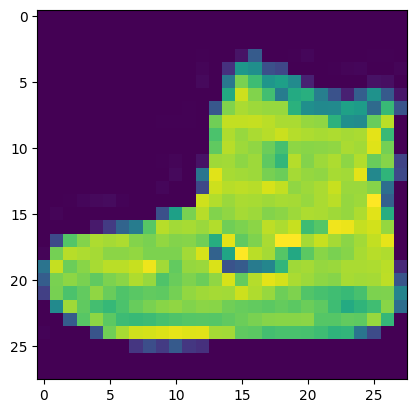

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.squeeze().numpy())
plt.show()

OK, that kinda sorta looks like a shoe? FashionMNIST is basically a bunch of black-white thumbnail images of different pieces of clothing. Let's try and plot a few of them. To step through the dataset, it will be helpful to construct a *data loader* object; we will use this while training our model below as well.

In [37]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

Let's now use the DataLoader object to spit out a few images from the dataset.

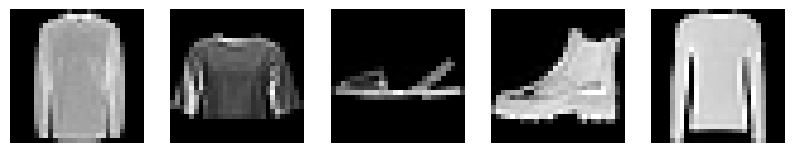

In [49]:
# Get a batch from the DataLoader
images, labels = next(iter(trainDataLoader))

plt.figure(figsize=(10, 4))
for index in range(5):
    plt.subplot(1, 5, index + 1)
    plt.imshow(images[index].squeeze().numpy(), cmap="gray")
    plt.axis("off")

OK! Time to set up our model. 

In [67]:
class DenseNN(torch.nn.Module):
    def __init__(self):
        super(DenseNN, self).__init__()
        self.flatten = torch.nn.Flatten() 
        self.hidden_layers = torch.nn.Sequential(
            torch.nn.Linear(28*28, 256),  
            torch.nn.ReLU(),              
            torch.nn.Linear(256, 128),    
            torch.nn.ReLU(),              
            torch.nn.Linear(128, 64),     
            torch.nn.ReLU(),             
            torch.nn.Linear(64, 10)       
        )

    def forward(self, x):
        x = self.flatten(x)          
        x = self.hidden_layers(x)    
        return x


net = DenseNN()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

Cool! Everything is set up. Let's now train our network.

In [68]:
train_loss_history = []
test_loss_history = []

for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images
    labels = labels
    optimizer.zero_grad()
    predicted_output = net(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images
      labels = labels
      predicted_output = net(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))

Epoch 0, Train loss 1.8125761956421298, Test loss 1.0752172325826754
Epoch 1, Train loss 0.8523993858142194, Test loss 0.7461548362188278
Epoch 2, Train loss 0.6759551525243056, Test loss 0.6490095696251863
Epoch 3, Train loss 0.5865685360899358, Test loss 0.5979943617134337
Epoch 4, Train loss 0.5404140290293866, Test loss 0.6383848957195404
Epoch 5, Train loss 0.5096830471174549, Test loss 0.5231036822886983
Epoch 6, Train loss 0.4862166849661992, Test loss 0.534411172768113
Epoch 7, Train loss 0.46959465532414696, Test loss 0.49234152476119386
Epoch 8, Train loss 0.4541985400513545, Test loss 0.4861040966715782
Epoch 9, Train loss 0.44068796031955465, Test loss 0.4739811210685475
Epoch 10, Train loss 0.42882088465350016, Test loss 0.48062344626256615
Epoch 11, Train loss 0.4178601308132031, Test loss 0.4712183577050069
Epoch 12, Train loss 0.40853701752703836, Test loss 0.43313428455856956
Epoch 13, Train loss 0.40084897744248926, Test loss 0.43371952756954607
Epoch 14, Train loss 0

Let's see how we did! We have tracked the losses so let's plot it.

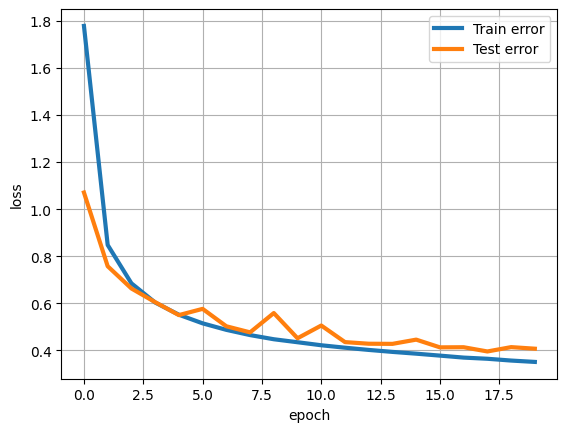

In [63]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

Not too bad (although more epochs would have helped, I suppose). Let's evaluate our final model on a few more images to wrap things up.

In [64]:
predicted_output = net(images)
print(torch.max(predicted_output, 1))
fit = Loss(predicted_output, labels)
print(labels)
print(fit)

torch.return_types.max(
values=tensor([ 7.1812,  3.4152, 12.5595, 10.7605,  8.4883,  8.9942, 10.8486,  6.6435,
         9.6817, 16.3470, 11.6636, 13.8882,  8.1963,  7.4778, 10.7418,  6.7980],
       grad_fn=<MaxBackward0>),
indices=tensor([3, 0, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5]))
tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5])
tensor(0.2203, grad_fn=<NllLossBackward0>)


Cool, looks like 2 images in this batch are being misclassified; can you (as a human) guess what those are?

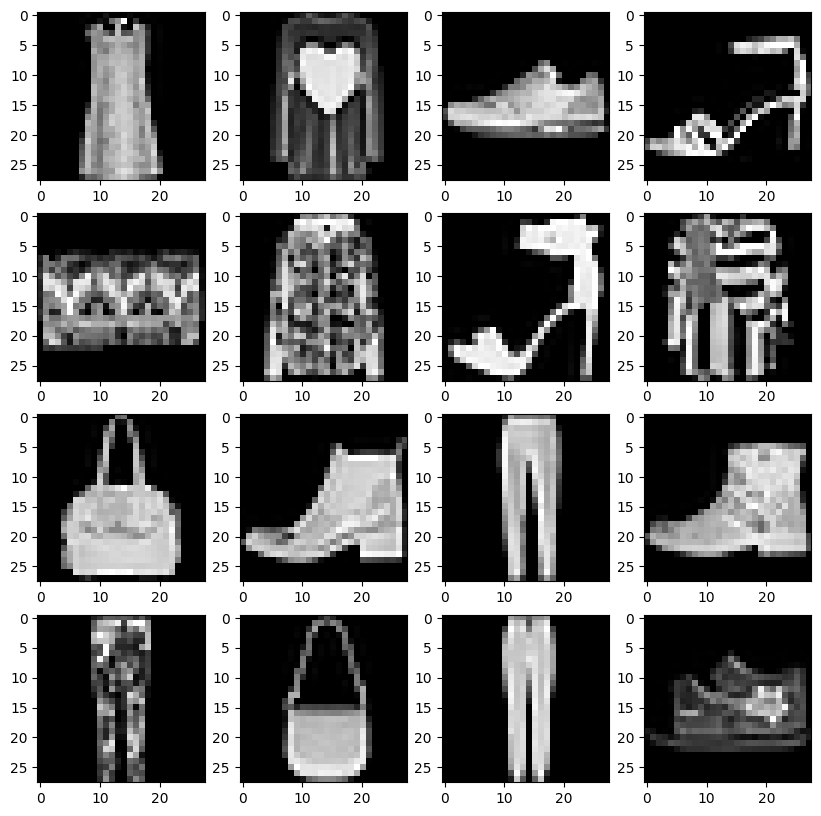

In [65]:
plt.figure(figsize=(10,10))
for index in np.arange(0,16):
  plt.subplot(4,4,index+1)
  plt.imshow(images[index].cpu().squeeze().numpy(),cmap=plt.cm.gray)